In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler

In [34]:
# Load and preprocess data
df = pd.read_csv('/content/pamap2_HAR_raw.csv')
df = df.head(25000)

In [35]:
# Linear Interpolation and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

In [36]:
# Feature Engineering
sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

In [37]:
# Min-Max Scaling
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

In [38]:
# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
sensor_data_scaled['activityID'] = df['activityID']
sensor_data_scaled['activity_name'] = df['activity_name']

In [39]:
# Train-Test Split (80% train, 20% test)
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp', 'activityID', 'activity_name'])


In [40]:
# Create sequences for Transformer input
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

In [41]:
# Define Transformer Encoder Layer
from tensorflow.keras.layers import MultiHeadAttention
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, input_shape): # Added input_shape
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(input_shape[-1]) # Changed output dimension to match input shape
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(0.1)
        self.dropout2 = Dropout(0.1)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Transformer Autoencoder
class TransformerAutoencoder(Model):
    def __init__(self, input_shape, num_heads=4, ff_dim=128):
        super(TransformerAutoencoder, self).__init__()
        self.encoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape) # Pass input_shape
        self.decoder_layer = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, input_shape=input_shape) # Pass input_shape
        self.dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs, training=None): # Added training argument
        encoded = self.encoder_layer(inputs, training=training) # Pass training to encoder_layer
        decoded = self.decoder_layer(encoded, training=training) # Pass training to decoder_layer
        decoded = self.dense(decoded)
        decoded = self.reshape_layer(decoded)
        return decoded

# Initialize and compile model
seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = TransformerAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

In [42]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 100ms/step - loss: 0.0480
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 91ms/step - loss: 0.0014
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 113ms/step - loss: 6.6077e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 92ms/step - loss: 4.2828e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 99ms/step - loss: 3.0075e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 91ms/step - loss: 2.2071e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - loss: 1.6333e-04
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 87ms/step - loss: 1.4186e-04
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - loss: 1.1587e-04
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - loss: 1.1158e-04
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - loss: 9.6474e-05
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 95ms/step - loss: 7.9738e-05
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 86ms/step - loss: 8.0140e-05
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 96ms/ste

In [43]:
# Function to Compute Anomaly-Based Rewards
def compute_unsupervised_rewards(X):
    reconstructed = autoencoder.predict(X)
    reconstruction_error = np.mean(np.abs(X - reconstructed), axis=2)
    threshold = np.percentile(reconstruction_error, 95, axis=0, keepdims=True)
    rewards = (reconstruction_error > threshold).astype(int)
    return rewards

# Generate Rewards
unsupervised_rewards = compute_unsupervised_rewards(X_train)
unsupervised_rewards = np.expand_dims(unsupervised_rewards, axis=-1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step


In [44]:
# Define PPO Agent
class PPOAgent(tf.keras.Model):
    def __init__(self, num_actions):
        super(PPOAgent, self).__init__()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(64, activation='relu')
        self.policy_logits = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.policy_logits(x)

# Instantiate PPO Agent
num_actions = 2
ppo_model = PPOAgent(num_actions)

In [45]:
# Define PPO Trainer
class PPOTrainer:
    def __init__(self, model, gamma=0.99, learning_rate=0.0001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def train(self, X, rewards, epochs=10):
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                logits = self.model(X)
                policy_out = tf.nn.softmax(logits)
                rewards = np.where(rewards > 0, 1, 0).astype(int)
                rewards = rewards.reshape(rewards.shape[0], rewards.shape[1])
                action_probs = tf.reduce_sum(policy_out * tf.one_hot(rewards, depth=2), axis=-1)
                loss = -tf.reduce_mean(tf.math.log(action_probs + 1e-10) * tf.cast(rewards, tf.float32))
            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

In [46]:
# Train PPO Model
ppo_trainer = PPOTrainer(ppo_model)
ppo_trainer.train(X_train, unsupervised_rewards, epochs=10)

Epoch 1/10, Loss: 0.0344
Epoch 2/10, Loss: 0.0340
Epoch 3/10, Loss: 0.0337
Epoch 4/10, Loss: 0.0334
Epoch 5/10, Loss: 0.0331
Epoch 6/10, Loss: 0.0328
Epoch 7/10, Loss: 0.0325
Epoch 8/10, Loss: 0.0322
Epoch 9/10, Loss: 0.0319
Epoch 10/10, Loss: 0.0316


156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


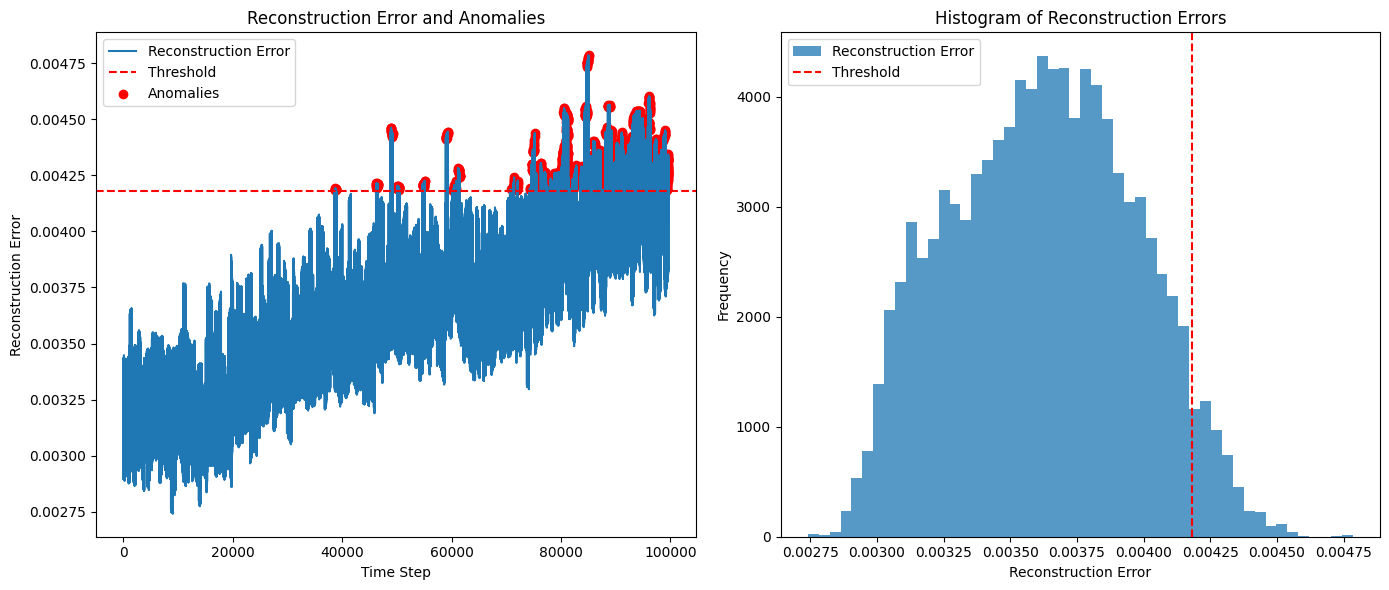

Total number of anomalies detected: 4980
Indices of anomalous points: [38597 38711 38730 ... 99594 99597 99599]
Reconstruction errors of anomalous points: [0.00418403 0.00418667 0.00419214 ... 0.00432331 0.00426827 0.0042423 ]


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute reconstruction error for the test set
reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)

# Compute the threshold for anomalies
threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

# Identify anomalies
anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

# Plot reconstruction error and anomalies
plt.figure(figsize=(14, 6))

# Plot reconstruction error
plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

# Plot histogram of reconstruction errors
plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()

plt.tight_layout()
plt.show()

# Print total number of anomalies
print(f"Total number of anomalies detected: {total_anomalies}")

# Print details of points marked as anomalous
anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])